# 설치, import, 구글 드라이브 마운트

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!git clone https://github.com/teddysum/korean_ABSA_baseline

In [ ]:
import json
import os

import torch
import torch.nn as nn
from tqdm import trange
from transformers import XLMRobertaModel, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
from datasets import load_metric
from sklearn.metrics import f1_score
import pandas as pd
import copy

import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Augmentation 함수 불러오기 (증강 전 준비)

In [ ]:
def jsonload(fname, encoding="utf-8"):
    with open(fname, encoding=encoding) as f:
        j = json.load(f)

    return j


# json 개체를 파일이름으로 깔끔하게 저장
def jsondump(j, fname):
    with open(fname, "w", encoding="UTF8") as f:
        json.dump(j, f, ensure_ascii=False)

# jsonl 파일 읽어서 list에 저장
def jsonlload(fname, encoding="utf-8"):
    json_list = []
    with open(fname, encoding=encoding) as f:
        for line in f.readlines():
            json_list.append(json.loads(line))
    return json_list

# jsonlload('/content/korean_ABSA_baseline/data/sample.jsonl')

In [ ]:
!git clone https://github.com/catSirup/KorEDA

In [ ]:
%cd KorEDA
!python eda.py

In [ ]:
from eda import *

In [ ]:
import random
import pickle
import re

with open('/content/KorEDA/wordnet.pickle', 'rb') as f:
	wordnet = pickle.load(f)
# data

In [ ]:
wordnet = {'아': ['아'],
 '오': ['오'],
 '와': ['와'],
 '예': ['예'],
 '올': ['올'],
 '우와': ['우와'],
 '이야': ['이야'],
 '음': ['음'],
 '어머나': ['어머나'],
 '이런': ['이런'],
 '아하': ['아하'],
 '으악': ['으악'],
 '오예': ['오예'],
 '이히': ['이히'],
 '어이쿠': ['어이쿠']
}

In [ ]:
import copy

def random_swap(words, n):
	new_words = copy.deepcopy(words)
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

In [ ]:
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

def get_synonyms(word):
    synomyms = []

    try:
        # if word not in wordnet:
            rand_num = random.randrange(0, len(wordnet) )
            synomyms.append(  list(wordnet.keys())[  rand_num  ]  )

        # else:
        #     for syn in wordnet[word]:
        #         synomyms.append(syn)
    except:
        pass

    return synomyms

# Augmentation할 파일 불러오기

In [ ]:
df_any =  pd.DataFrame(jsonlload("/content/korean_ABSA_baseline/data/sample.jsonl"))


In [ ]:
#####    make dataframe anything   #####

dic_add = {
    'sentence_form' : [],
    'type' : [],
    'topic' : [],
    'annotation_split' : [],
    'annotation' : []
}

for i in range(len( df_any )):
    a = re.findall("(\[\'.+?\'\])", str(df_any['annotation'][i]))
    # len_a = len( a )

    tmp_type = []
    tmp_topic = []

    for j in a:
        tmp_j = re.findall("'(.+?)'", str(j))
        tmp_type.append(  tmp_j[0]  )
        if len(tmp_j) == 3:
            tmp_topic.append(  tmp_j[1].replace("ax0", "")  )
        else:
            tmp_topic.append( None )

    dic_add['sentence_form'].append(  df_any['sentence_form'][i]  )
    dic_add['type'].append(  tmp_type  ) 
    dic_add['topic'].append(  tmp_topic  ) 
    dic_add['annotation_split'].append(  a  )
    dic_add['annotation'].append(  df_any['annotation'][i]  ) 


df_add_cat = pd.DataFrame( dic_add )
df_add_cat


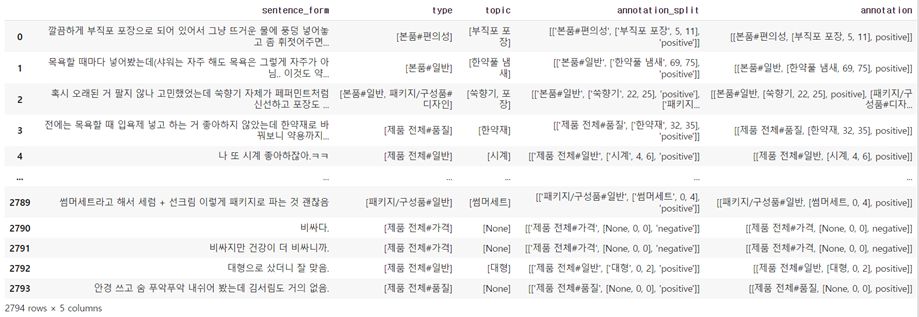

# Augmentation 시작

## 증강 시작
증강하고자 하는 데이터를 df_i made로 설정하고 증강 시작

In [ ]:
augmentation = {
    'sentence_form' : [],
    'annotation' : []
}

### polarity

In [ ]:
def pola(x):

    ### 필요 코드 수정  ###

    if 'neutral' not in str(x) and 'negative' in str(x) and 'positive' not in str(x):

    #######################

        return True
    else:
        return False

In [ ]:
### 긍정 부정 중립 ###

category = "negative"

df_imade = df_add_cat[df_add_cat['annotation'].apply(pola)]
df_imade = df_imade.reset_index(drop=True)
# df_imade

### category

In [ ]:
category = '본품#일반'

# '본품#인지도' 같은걸 쓰세요

In [ ]:
def finder(x):
    if category in x: 
        return True
    else:
        return False

In [ ]:
df_imade = df_add_cat[df_add_cat['type'].apply(finder)]
df_imade = df_imade.reset_index(drop=True)
# df_imade

## 증강 설명
- 증강으로 생성된 문장에 topic들이 삭제된다면, (여러개 토픽 포함)
- 새로운 문장을 생성합니다. 
- 만약 100번 반복했음에도 topic들이 삭제된다면 그 문장은 증강 불가라고 생각하고 증강하지 않고 넘어갑니다. (보통 짧은 문장일 경우에 해당) 

### random_swap  (RS)

- n은 swap을 몇 번 실행 할건지
- counts는 문장 하나당 몇 번 증강할건지 

- 다만 counts는 A 문장을 A'  A''  A''' 만들고 B를 B'  B'' B''' 만듭니다.
- 원본 데이터를 순서대로 증강하고 싶다면 counts를 1로 주고 여러번 실행하는게 좋습니다.

In [ ]:
# random_swap  (RS)

num = len(df_imade)

n = 1 #@param {type:"slider", min:1, max:4, step:1}
counts = 1 #@param {type:"slider", min:1, max:50, step:1}

for i in range(num):
    guard = 0
    count = 0
    while count < counts:
        if guard > 100:
            break
        # sentence를 swap해서 새로 만든다
        tmp = ' '.join( random_swap( df_imade['sentence_form'][i].split(), n) ) 
        # topic이 None이거나  새로 만든 sentence에 없으면  sentence를 새로 만든다

        in_flag = True
        for j in df_imade['topic'][i]:
            if j == 'None' or j == None:
                continue
            if j not in tmp:
                in_flag = False
    
        if in_flag == False:
            guard += 1
            continue

        else:  # tmp 안에 토픽들이 다 있다면  생성한 문장 추가
            augmentation['sentence_form'].append(  tmp  )
            tmp_topic = []

            annotations = []
            an_split = df_imade['annotation_split'][i]
            # for k in an_split:
            #     for m in df_imade['topic'][i]:
        
            for k, m in zip(an_split,df_imade['topic'][i]) :
                k = str(k)
                if '\'\'' in k:
                    k = k.replace("\'\'", 'null')
                tmp_k = []
                tmp_k2 = []
                tmp_topic = re.findall("'(.+?)'", k)
                tmp_k.append( tmp_topic[0].replace("[", "").replace("]", "")  )

                if len(tmp_topic) == 2: # topic이 None이어서 길이가 2일 때
                    tmp_k2.append(  None  )
                    tmp_k2.append(  0  )
                    tmp_k2.append(  0  )
                else:
                    tmp_k2.append(  tmp_topic[1]  )
                    tmp_k2.append(  tmp.index(tmp_topic[1])  )
                    tmp_k2.append(  tmp.index(tmp_topic[1]) + len(tmp_topic[1])  )

                tmp_k.append(  tmp_k2  )

                tmp_k.append( tmp_topic[-1]  )
                annotations.append( tmp_k )
            
            annotations = str(annotations)
            
            augmentation['annotation'].append( annotations )

        count += 1



### random_deletion  RD

- p는 각 단어마다 몇의 확률로 deletion 할건지
- counts는 문장 하나당 몇 번 증강할건지 


- p가 0이면 각 단어들을 0% 확률로 삭제 : 원본 유지
- p가 0.4면  각 단어들을 40% 확률로 삭제 



- 다만 counts는 A 문장을 A'  A''  A''' 만들고 B를 B'  B'' B''' 만듭니다.
- 원본 데이터를 순서대로 증강하고 싶다면 counts를 1로 주고 여러번 실행하는게 좋습니다.

In [ ]:
# random_deletion  RD


num = len(df_imade) 

p = 0 #@param {type:"slider", min:0.0, max:0.4, step:0.1}

counts = 1 #@param {type:"slider", min:1, max:50, step:1}

for i in range(num):
    guard = 0
    count = 0
    while count < counts:
        if guard > 100:
            break
        # sentence를 deletion해서 새로 만든다
        tmp = ' '.join( random_deletion( df_imade['sentence_form'][i].split(), p) ) 


        # topic이 None이거나  새로 만든 sentence에 없으면  sentence를 새로 만든다
        in_flag = True
        for j in df_imade['topic'][i]:
            if j == 'None' or j == None:
                continue
            if j not in tmp:
                in_flag = False
    
        if in_flag == False:
            guard += 1
            continue

        else:  # tmp 안에 토픽들이 다 있다면  생성한 문장 추가
            augmentation['sentence_form'].append(  tmp  )
            tmp_topic = []

            annotations = []
            an_split = df_imade['annotation_split'][i]
        
            for k, m in zip(an_split,df_imade['topic'][i]) :
                k = str(k)
                if '\'\'' in k:
                    k = k.replace("\'\'", 'null')
                tmp_k = []
                tmp_k2 = []
                tmp_topic = re.findall("'(.+?)'", k)
                tmp_k.append( tmp_topic[0].replace("[", "").replace("]", "")  )

                if len(tmp_topic) == 2: # topic이 None이어서 길이가 2일 때
                    tmp_k2.append(  None  )
                    tmp_k2.append(  0  )
                    tmp_k2.append(  0  )
                else:
                    tmp_k2.append(  tmp_topic[1]  )
                    tmp_k2.append(  tmp.index(tmp_topic[1])  )
                    tmp_k2.append(  tmp.index(tmp_topic[1]) + len(tmp_topic[1])  )

                tmp_k.append(  tmp_k2  )

                tmp_k.append( tmp_topic[-1]  )
                annotations.append( tmp_k )
            
            annotations = str(annotations)
            
            augmentation['annotation'].append( annotations )

        count += 1

### random_insertion  RI

- n는 단어를 몇 개 삽입할건지
- counts는 문장 하나당 몇 번 증강할건지 

- 삽입된 단어들은 랜덤한 위치로 들어갑니다.


- 다만 counts는 A 문장을 A'  A''  A''' 만들고 B를 B'  B'' B''' 만듭니다.
- 원본 데이터를 순서대로 증강하고 싶다면 counts를 1로 주고 여러번 실행하는게 좋습니다.

In [ ]:
# random_insertion  RI

num = len(df_imade) 

n = 1 #@param {type:"slider", min:1, max:7, step:1}

counts = 1 #@param {type:"slider", min:1, max:50, step:1}

for i in range(num):
    guard = 0
    count = 0
    while count < counts:
        if guard > 100:
            break
        tmp = ' '.join( random_insertion( df_imade['sentence_form'][i].split(), n) )      

        # topic이 None이거나  새로 만든 sentence에 없으면  sentence를 새로 만든다
        in_flag = True
        for j in df_imade['topic'][i]:
            if j == 'None' or j == None:
                continue
            if j not in tmp:
                in_flag = False
    
        if in_flag == False:
            guard += 1
            continue

        else:  # tmp 안에 토픽들이 다 있다면  생성한 문장 추가
            augmentation['sentence_form'].append(  tmp  )
            tmp_topic = []

            annotations = []
            an_split = df_imade['annotation_split'][i]
        
            for k, m in zip(an_split,df_imade['topic'][i]) :
                k = str(k)
                if '\'\'' in k:
                    k = k.replace("\'\'", 'null')
                tmp_k = []
                tmp_k2 = []
                tmp_topic = re.findall("'(.+?)'", k)
                tmp_k.append( tmp_topic[0].replace("[", "").replace("]", "")  )

                if len(tmp_topic) == 2: # topic이 None이어서 길이가 2일 때
                    tmp_k2.append(  None  )
                    tmp_k2.append(  0  )
                    tmp_k2.append(  0  )
                else:
                    tmp_k2.append(  tmp_topic[1]  )
                    tmp_k2.append(  tmp.index(tmp_topic[1])  )
                    tmp_k2.append(  tmp.index(tmp_topic[1]) + len(tmp_topic[1])  )

                tmp_k.append(  tmp_k2  )

                tmp_k.append( tmp_topic[-1]  )
                annotations.append( tmp_k )
            
            annotations = str(annotations)
            
            augmentation['annotation'].append( annotations )

        count += 1

## 증강 결과 확인 및 저장

In [ ]:
# 개수 확인
len(augmentation['sentence_form']), len(augmentation['annotation'])

In [ ]:
# dataframe으로 만들기
df_augmentation = pd.DataFrame( augmentation )

# 원본 데이터와 증강한 데이터를 합치려면 바로 아래코드 주석을 해제하세요.
# df_augmentation = pd.concat([df_augmentation, df_any])

df_augmentation = df_augmentation.drop_duplicates('sentence_form')
df_augmentation = df_augmentation.sample(frac = 1) 
df_augmentation = df_augmentation.reset_index(drop=True) 
df_augmentation

In [ ]:
# jsonl 파일로 저장하기

print(category, len(df_augmentation)) # 카테고리와, df 개수 확인

category = category.replace("/", "")         # 패키지/구성품  카테고리 중에서  '/' 를 폴더로 인식하길래 이름에서만 제외
file_name = '{0}_001' .format(category)  # ←, ↓ 숫자를 이전버전과 겹치지 않게, 주소 위치를 설정하고 실행하면 자동 저장됨

with open('/content/{0}.jsonl' .format(file_name), 'w') as file:
    for i in range( len(df_augmentation) ):
        annos = df_augmentation['annotation'][i]
        str_annos = str(annos)
        tmp = str_annos.replace("None", "null").replace("\'", "\"")

        file.write(  '{'+'\"id\": \"nikluge-sa-2022-{3}-{0}\", \"sentence_form\": \"{1}\", \"annotation\": {2}'\
                    .format( str(i+1).zfill(5)  ,   df_augmentation['sentence_form'][i], tmp, file_name ) +'}' )
        file.write("\n")

# 문장 예시
# {"id": "nikluge-sa-2022-dev-00001", "sentence_form": "깔끔하게 부직포 포장으로 되어 있어서 그냥 뜨거운 물에 풍덩 넣어놓고 좀 휘젓어주면 금방 우러난다.", "annotation": [["본품#편의성", ["부직포 포장", 5, 11], "positive"]]}

# {0}은 숫자, {1}은 sentence, {2}는 annotation, {3}은 file_name(파일이름)


## 잘 열리는지 test

In [ ]:
df_test =  pd.DataFrame(jsonlload("/content/{0}.jsonl". format(file_name)))
df_test